*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*



# Understand your NLP models

This is a torturial on how to utilize Interpreter class to explain certain hidden layers in your NLP models. We provide the explanation by measuring the information of input words ${\bf x}_1,...,{\bf x}_n$ that is encoded in hidden state ${\bf s} = \Phi({\bf x})$. The method is from paper [*Towards a Deep and Unified Understanding of Deep Neural Models in NLP*](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) that is accepted by **ICML 2019**. In this torturial, we provide a simple example for you to start quickly.

In [1]:
import torch
from torch import nn
import sys

sys.path.append("../../")

from utils_nlp.interpreter.Interpreter import calculate_regularization, Interpreter

## 0 Prepare necessary components
Suppose the $\Phi$ we need to explain is a simple linear function:
$$\Phi(x)=10 \times x[0] + 20 \times x[1] + 5 \times x[2] - 20 \times x[3] - 10 \times x[4]$$
From the definition of $\Phi$ we can know that, the weights of the 2nd and the 4th elements in input $x$ are the biggest (in abs form), which means that they contributes the most to the results. Therefore, a reasonable explanation should show a similar pattern.

In [2]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

# Suppose our input is x, and the sentence is simply "1 2 3 4 5"
x = torch.randn(5, 256) / 100
x = x.to(device)
words = ["1", "2", "3", "4", "5"]

# Suppose our hidden state s = Phi(x), where
# Phi = 10 * word[0] + 20 * word[1] + 5 * word[2] - 20 * word[3] - 10 * word[4]
def Phi(x):
    W = torch.tensor([10.0, 20.0, 5.0, -20.0, -10.0]).to(device)
    return W @ x


# Suppose this is our dataset used for training our models
dataset = [torch.randn(5, 256) / 100 for _ in range(100)]

## 1 Using Mutual Information to understand $\Phi$

We briefly introduce our algorithms here. You can also refer to our paper [here](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) for more details on algorithm.

### 1.1 Multi-level Quantification

Suppose the input random variable is $\bf X$ and the hidden random variable ${\bf S} = \Phi({\bf X})$. We can provide a global/corpus-level explanation by evaluating the mutual information of $\bf X$ and $\bf S$:

$$MI({\bf X};{\bf S})=H({\bf S}) - H({\bf H}|{\bf S})$$

Where $MI(\cdot;\cdot)$ is the mututal information. $H(\cdot)$ stands for entropy. Because $H({\bf S})$ is a constant only related to input dataset $\bf S$, the only thing we need to consider is $H({\bf H}|{\bf S})$. This conditional entropy can be seen as the global/corpus-level information loss when r.v. $\bf X$ is processed by $\Phi$. By definition:

$$H({\bf X}|{\bf S}) = \int_{{\bf s}\in {\bf S}}p({\bf S})H({\bf X}|{\bf s})d{\bf s}$$

Then, we can decompose the corpus-level information loss to sentence-level:

$$H({\bf X}|{\bf s}) = \int_{{\bf x'}\in {\bf X}}p({\bf x}'|{\bf s})H({\bf x}'|{\bf s})d{\bf x}'$$

If we make a assumption that the inputs of $\Phi$ are independent, we can further decompose the sentence-level information loss to word level:

$$H({\bf X}|{\bf s}) = \sum_i H({\bf X}_i|{\bf s})$$
$$H({\bf X}_i|{\bf s}) = \int_{{\bf x'}_i\in {\bf X}_i}p({\bf x}_i'|{\bf s})H({\bf x}_i'|{\bf s})d{\bf x}_i'$$

Note that $H({\bf X}_i|{\bf s})$ stands for the information loss when word ${\bf x}_i$ reaches hidden state $s$. Therefore, we can use this value as our explanation. Higher value stands for the information of corrsponding word is largely lost, which means that this word is less important to $\bf s$, and vice versa.

### 1.2 Perturbation-based Approximation

In order to calculate $H({\bf X}_i|{\bf s})$, we propose a perturbation-besed method. Let $\tilde{\bf x}_{i}={\bf x}_{i} +{\boldsymbol \epsilon}_{i}$ denote an input with a certain noise $\boldsymbol{\epsilon}_{i}$. We assume that the noise term is a random variable that follows a Gaussian distribution, ${\boldsymbol{\epsilon}_{i}}\in \mathbb{R}^{K}$ and ${\boldsymbol \epsilon}_i\sim{\mathcal N}({\bf0},{\boldsymbol\Sigma}_{i}=\sigma_{i}^2{\bf I})$. 
In order to approximate $H({\bf X}_i|{\bf s})$, we first learn an optimal distribution of ${\boldsymbol{\epsilon}} = [{\boldsymbol{\epsilon}}_1^T, {\boldsymbol \epsilon}_2^T, ..., {\boldsymbol \epsilon}_n^T]^T$ with respect to the hidden state 
${\bf s}$ with the following loss:

$$L({\boldsymbol \sigma})=\mathbb{E}_{{\boldsymbol \epsilon}}\Vert\Phi(\tilde{\bf x})-{\bf s}\Vert^2-\lambda\sum_{i=1}^n H(\tilde{\bf X}_{i}|{\bf s})|_{{\boldsymbol\epsilon}_{i}\sim{\mathcal N}({\bf 0},\sigma_{i}^2{\bf I})}$$

where $\lambda>0$ is a hyper-parameter, ${\boldsymbol \sigma}=[\sigma_1,...,\sigma_n]$, and $\tilde{\bf x} = {\bf x} + \boldsymbol{\epsilon}$. The first term  on the left corresponds to the maximum likelihood estimation (MLE) of the distribution of $\tilde{\bf x}_{i}$ that maximizes $\sum_{i}\sum_{\tilde{\bf x}_{i}}\log p(\tilde{\bf x}_{i}|{\bf s})$, if we consider $\sum_{i}\log p(\tilde{\bf x}_{i}|{\bf s})\propto -\Vert\Phi(\tilde{\bf x})-{\bf s}\Vert^2$. In other words, the first term learns a distribution that generates all potential inputs corresponding to the hidden state ${\bf s}$. The second term on the right encourages a high conditional entropy $H(\tilde{\bf X}_{i}|{\bf s})$, which corresponds to the maximum entropy principle. In other words, the noise $\boldsymbol \epsilon$ needs to enumerate all perturbation directions to reach the representation limit of ${\bf s}$. By minimizing the loss above, we can get the optimal ${\sigma}_i$, then we can get the $H(\tilde{\bf X}_i|{\bf s})$:

$$H(\tilde{\bf X}_{i}|{\bf s})=\frac{K}{2}\log(2\pi e)+K\log\sigma_{i}$$

Then, we can use $H(\tilde{\bf X}_i|{\bf s})$ to approximate $H({\bf X}_i|{\bf s})$. Again, you can refer to our paper [here](https://www.microsoft.com/en-us/research/publication/towards-a-deep-and-unified-understanding-of-deep-neural-models-in-nlp/) for more details on algorithm.

## 2 Create an Interpreter instance

In the following, we'll show you how to calculate the $\sigma_i$ using functions this library. To explain a certain $\bf x$ and certain $\Phi$, we need to create an Interpreter instance, and pass your $\bf x$, $\Phi$ and regularization term (which is the standard variance of the hidden state r.v. $\bf S$) to it. We also provide a simple function to calculate the regularization term that is needed in this method.

In [3]:
# calculate the regularization term.
regularization = calculate_regularization(dataset, Phi, device=device)

# create the interpreter instance
# we recommend you to set hyper-parameter *scale* to 10 * Std[word_embedding_weight], 10 * 0.1 in this example
interpreter = Interpreter(
    x=x, Phi=Phi, regularization=regularization, scale=10 * 0.1, words=words
)
interpreter.to(device)

Interpreter()

## 3 Train the Interpreter

Then, we need to train our interpreter (by minimizing the loss [here](#1.2-Perturbation-based-Approximation)) to let it find the information loss in each input word ${\bf x}_i$ when they reach hidden state $\bf s$. You can control the iteration and learning rate when training.

In [4]:
# Train the interpreter by optimizing the loss
interpreter.optimize(iteration=5000, lr=0.5, show_progress=True)

100%|██████████| 5000/5000 [00:08<00:00, 601.76it/s]


## 4 Show and visualize results

After training, we can show the sigma (directly speaking, it is the range that every word can change without changing $\bf s$ too much) we have got. Sigma somewhat stands for the information loss of word ${\bf x}_i$ when it reaches $\bf s$.

In [5]:
# Show the sigma we get
interpreter.get_sigma()

array([0.00315241, 0.00157062, 0.00633752, 0.00157459, 0.00313454],
      dtype=float32)

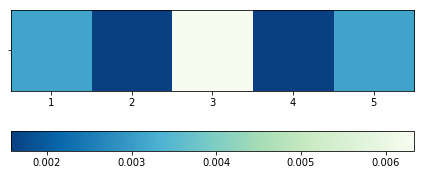

In [6]:
# Visualize the information loss of our sigma
interpreter.visualize()

We can see that the second and forth words are important to ${\bf s} = \Phi({\bf x})$, which is reasonable because the weights of them are larger.